In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
df = pd.read_csv('bbq_data.csv', skiprows=1)

In [144]:
df.dtypes

Month                   object
bbq: (United States)     int64
dtype: object

In [145]:
df['Month'] = pd.to_datetime(df['Month'])

In [146]:
df.dtypes

Month                   datetime64[ns]
bbq: (United States)             int64
dtype: object

In [147]:
df.columns = ['month', 'searches']

In [148]:
df.set_index('month', inplace=True)

In [149]:
df.head()

,searches
month,
2004-01-01,10
2004-02-01,11
2004-03-01,14
2004-04-01,15
2004-05-01,22


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 2004-01-01 to 2020-09-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   searches  201 non-null    int64
dtypes: int64(1)
memory usage: 3.1 KB


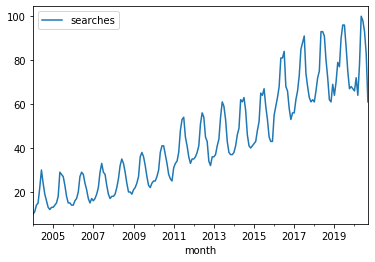

In [151]:
df.plot()

In [152]:
len(df)

201

In [153]:
df.head()

,searches
month,
2004-01-01,10
2004-02-01,11
2004-03-01,14
2004-04-01,15
2004-05-01,22


In [154]:
test_size = 18
test_index = len(df) - test_size

In [155]:
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [156]:
train

,searches
month,
2004-01-01,10
2004-02-01,11
2004-03-01,14
2004-04-01,15
2004-05-01,22
...,...
2018-11-01,61
2018-12-01,69
2019-01-01,64


In [157]:
test

,searches
month,
2019-04-01,77
2019-05-01,90
2019-06-01,96
2019-07-01,96
2019-08-01,86
2019-09-01,75
2019-10-01,67
2019-11-01,68
2019-12-01,67


In [158]:
from sklearn.preprocessing import MinMaxScaler

In [159]:
scaler = MinMaxScaler()

In [160]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [161]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [162]:
len(scaled_test)

18

In [163]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [164]:
length = 12 
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [166]:
n_features = 1 

In [167]:
model = Sequential()

model.add(LSTM(200, activation='relu', input_shape=(length, n_features)))

model.add(Dense(50))

model.add(Dense(10))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [168]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_6 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 172,171
Trainable params: 172,171
Non-trainable params: 0
_________________________________________________________________


In [169]:
from tensorflow.keras.callbacks import EarlyStopping

In [170]:
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [171]:
model.fit(generator, validation_data=validation_generator, epochs=20, callbacks=[early_stop])

Epoch 1/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0229 - val_loss: 0.0449
Epoch 2/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss: 0.0426
Epoch 3/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0110 - val_loss: 0.0544
Epoch 4/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.0433
Epoch 5/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0089 - val_loss: 0.0286
Epoch 6/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0045 - val_loss: 0.0186
Epoch 7/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0036 - val_loss: 0.0124
Epoch 8/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0148
Epoch 9/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 0.0129
Epoch 10/20
171/171 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0200

In [172]:
losses_df = pd.DataFrame(model.history.history)

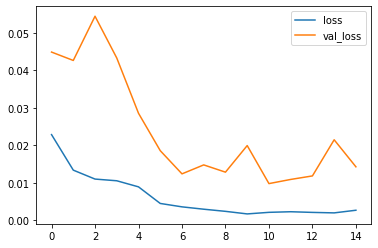

In [173]:
losses_df.plot()

In [174]:
first_eval_batch = scaled_train[-length:]
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [175]:
model.predict(first_eval_batch)

array([[0.9240376]], dtype=float32)

In [176]:
scaled_test[0]

array([0.80722892])

In [177]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [178]:
true_predictions = scaler.inverse_transform(test_predictions)

In [179]:
test['LSTM Pred'] = true_predictions

C:\Users\sfste\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


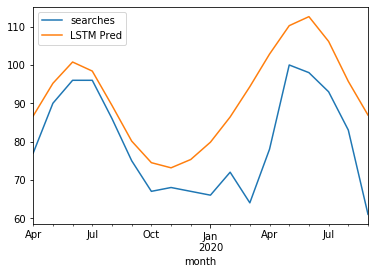

In [180]:
test.plot()

In [181]:
full_scaler = MinMaxScaler()
full_scaled_data = full_scaler.fit_transform(df)

In [182]:
forcast = []

first_eval_batch = full_scaled_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    forcast.append(current_pred)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [183]:
forcast = scaler.inverse_transform(forcast)

In [184]:
forcast

array([[60.29573965],
       [60.72763389],
       [63.27698785],
       [67.24974108],
       [72.33652133],
       [79.278229  ],
       [87.5173806 ],
       [95.61496353],
       [99.01732111],
       [92.97496229],
       [83.0605799 ],
       [75.39934367],
       [71.61598355],
       [72.21961439],
       [75.43659103],
       [80.52953053],
       [87.7067737 ],
       [95.69627547]])

In [186]:
forcast_index = pd.date_range(start='2020-10-01', periods=18, freq='MS')

In [185]:
df.tail()

,searches
month,
2020-05-01,100
2020-06-01,98
2020-07-01,93
2020-08-01,83
2020-09-01,61


In [187]:
forcast_df = pd.DataFrame(data=forcast, index=forcast_index, columns=['Forcast'])

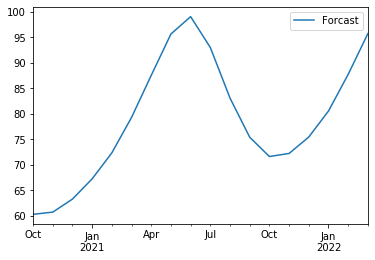

In [189]:
forcast_df.plot()

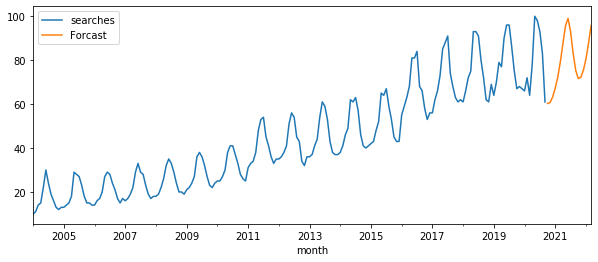

In [196]:
ax = df.plot()
forcast_df.plot(ax=ax, figsize=(10, 4))
